# Models

In [7]:
#Dependencies
import os
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
## import libraries for ARIMA
from fbprophet import Prophet
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder 
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow import keras
#show current versions
print("Tensorflow Version:",tf.__version__)
print("Keras Version", keras.__version__)

Tensorflow Version: 2.1.0
Keras Version 2.2.4-tf


## Datasets

In [8]:
path = "./datasets/"
#check location of files
os.getcwd()

'/Users/jacosta3/OneDrive - University of South Florida/Gerdau Projects/pft/submission'

In [9]:
#import data sets
weekly = pd.read_csv(path+'structuralweekly_with_indicators.csv')
monthly = pd.read_csv(path+'structuralmonthly_with_indicators.csv')

In [15]:
#see format
weekly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12519 entries, 0 to 12518
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   calendar_day                12519 non-null  object 
 1   year                        12519 non-null  int64  
 2   month                       12519 non-null  int64  
 3   global_steel_utilization    12519 non-null  float64
 4   fed_construction$B          12519 non-null  int64  
 5   state_local_construction$B  12519 non-null  int64  
 6   carbon_bar_ship_usa         12519 non-null  int64  
 7   carbon_bar_ship_canada      12519 non-null  int64  
 8   structural_ship_usa         12519 non-null  int64  
 9   structural_ship_canada      12519 non-null  int64  
 10  ism_manufacturing           12519 non-null  float64
 11  ism_non_manufacturing       12519 non-null  float64
 12  chicago_scrap$ST            12519 non-null  int64  
 13  block                       125

## Data Prep

### Weekly

In [34]:
# Splitting by years with uneven data points per year
# Source: https://stackoverflow.com/questions/58069691/how-to-create-a-train-test-split-of-time-series-data-by-year
year_list = weekly['year'].unique().tolist()
weekly_splits = {'train': [], 'test': []}

for idx, yr in enumerate(year_list[:-1]):
    train_yr = year_list[:idx+1]
    test_yr = [year_list[idx+1]]
    print('TRAIN: ', train_yr, 'TEST: ',test_yr)

    weekly_splits['train'].append(weekly.loc[weekly.year.isin(train_yr), :])
    weekly_splits['test'].append(weekly.loc[weekly.year.isin(test_yr), :])

print('\n')
# Exception, we only have 3 series (2019 + 2020) should be aggregated(if 2020 is used)
print("Size of the Train-Test Splits:")
print("Train 2016:",weekly_splits['train'][0].shape[0])
print("  Test 2017:",weekly_splits['test'][0].shape[0])
print("Train 2016-17:",weekly_splits['train'][1].shape[0])
print("  Test 2018:",weekly_splits['test'][1].shape[0])
print("Train 2016-18:",weekly_splits['train'][2].shape[0])
print("  Test 2019:",weekly_splits['test'][2].shape[0])
print("Train 2016-19:",weekly_splits['train'][3].shape[0])
print("  Test 2020:",weekly_splits['test'][3].shape[0])

TRAIN:  [2016] TEST:  [2017]
TRAIN:  [2016, 2017] TEST:  [2018]
TRAIN:  [2016, 2017, 2018] TEST:  [2019]
TRAIN:  [2016, 2017, 2018, 2019] TEST:  [2020]


Size of the Train Test Splits:
Train 2016: 2867
  Test 2017: 3328
Train 2016-17: 6195
  Test 2018: 3260
Train 2016-18: 9455
  Test 2019-2020: 3018
Train 2016-19: 12473
  Test 2020: 46


## Metrics

In [ ]:
#notes on why these metrics and source
#Source: https://medium.com/@joydeepubuntu/common-metrics-for-time-series-analysis-f3ca4b29fe42

In [175]:
def score_model(test_y, test_x, model, api=None,):
    '''
    scoring function to be used across model.
    parameters - 
        test_y: dataframe with y located in the last row
        test_x: dataframe with dependent variables for model ingestion
        model: trained model
        api: 'tf':tensorflow, 'prophet':facebook prophet
    notes:
        for prophet input the 'future' df as test_x, that function will filter out the needed dataframe
    '''
    test_y = test_y.iloc[:,-1]
    if api == 'tf':
        pass #pred_y =     
    elif api == 'prophet':
        forecast = prophet.predict(test_x)
        pred_y = forecast[forecast['ds'].dt.year >=2019][['ds','yhat']].rename(columns={'yhat':'y'}).iloc[:,-1]
    else:
        pred_y = model.predict(test_x)
    r2 = r2_score(test_y, pred_y)
    mae = mean_absolute_error(test_y,pred_y)
    rmse = mean_squared_error(test_y, pred_y, squared=False)
    print("Test Scores:", )
    print("  Mean Absolute Error(MAE):",mae)
    print("  Root Mean Squared Error(RMSE):",rmse)
    print("  Coefficient of Determination(R2):",r2)
    print("Take 4 Sample Comparison:")
    print("  Predictions:", pred_y.iloc[0:4].to_numpy().round().astype(int).transpose())
    print("      Actuals:", test_y.iloc[0:4].to_numpy().transpose())

Because we know shipments have heavy tails, that are skewed on the left we decided to use MAE as our main scoring, however in comparing models we want to make note of the other metrics(RMSE and R2) that maybe give us an overall understanding of how our models are performing and in what arena a certain model may perform better

# Prophet Univariate

In [84]:
#setting train (2016-2018), test (2019-2020)
train = weekly_splits['train'][2]
test = weekly_splits['test'][2].append(weekly_splits['test'][3], ignore_index=True)

Only one block for analysis: 4" ANG

In [85]:
#filtering block for analysis
train_block = train[train['block']=='4" ANG']
test_block = test[test['block']=='4" ANG']
#size decreases significantly - this could help/hurt
train_block.shape

(157, 18)

In [89]:
#setting up to univariate, prophet ingestion
train_block = train_block.rename(columns={'calendar_day':'ds', 'shipment_tons':'y'})[['ds','y']]
test_block = test_block.rename(columns={'calendar_day':'ds', 'shipment_tons':'y'})[['ds','y']]

#adding a floor for training set
# train_block['cap'] = 2000 #caps seem to have worsen model
# train_block['floor'] = 0 #floors seem to have worsen model

In [90]:
#peek at df
train_block.head(2)

,ds,y
16,1/3/16,0
76,1/10/16,297


### Set-Up & Fitting

In [91]:
#instantiating prophet model with an additive seasonal model, looking at yearly seasonality
prophet = Prophet(seasonality_mode="additive", yearly_seasonality=True,)

prophet.fit(train_block)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Predicting

In [92]:
#creates future calendar with actual dates in training & future dates (determined)
future = prophet.make_future_dataframe(periods=53, freq='W')

#setting up floor and cap
# future['cap'] = 2000 #caps seem to have worsen model
# future['floor'] = 0 #floor seem to have worsen model

In [93]:
#predict future
forecast = prophet.predict(future)

### View Forecast Plot & Components 

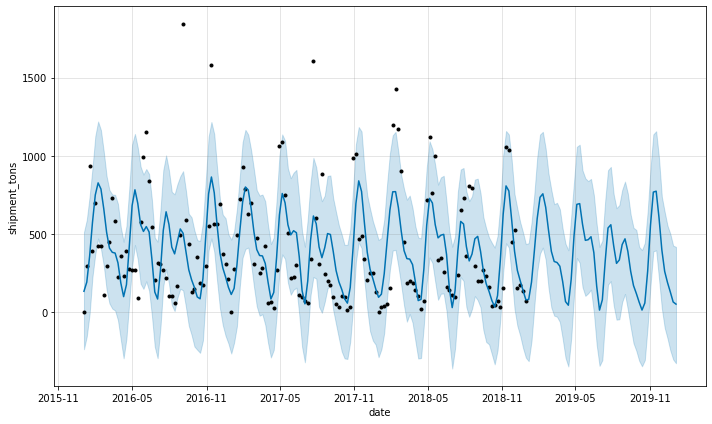

In [94]:
#plot projected shipments
#dark-blue: y_hat(prediction)
#shade-blue: uncertainty interval (range of values at 95%)
#dots: actual points
#dashed lines: cap and floor levels
prophet.plot(forecast, xlabel='date', ylabel='shipment_tons');

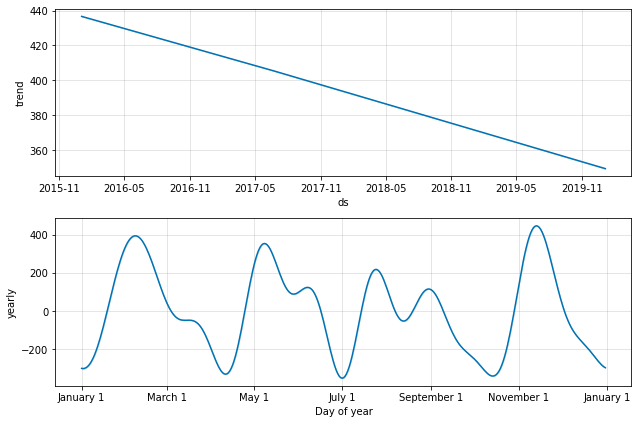

In [95]:
#look at components
#overall trend
#yearly seasonally presented
prophet.plot_components(forecast);

### Scoring

In [98]:
#Metrics provided by prophet make use of cross-validation and applies it to the known years in this case 2017-2018
evaluate = cross_validation(prophet, initial="52 W", horizon="4 W", period="1 W")
%time

INFO:fbprophet:Making 101 forecasts with cutoffs between 2017-01-01 00:00:00 and 2018-12-02 00:00:00
CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 16 µs


In [99]:
#see metrics scores for 
performance_metrics(evaluate)

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,7 days,137769.884349,371.173658,278.737816,0.670742,0.702970
1,14 days,174344.483846,417.545787,316.483349,0.748165,0.603960
2,21 days,182927.649323,427.700420,327.289126,0.771558,0.594059
3,28 days,183226.694307,428.049874,327.041020,0.773595,0.574257


#### Cross-model evaluation
Predicting on 2019-20 test-set

In [176]:
#Scoring based on 2019-20 test set
score_model(test_block, future, prophet, api='prophet')

Test Scores:
  Mean Absolute Error(MAE): 216.66172387349795
  Root Mean Squared Error(RMSE): 291.39714114195937
  Coefficient of Determination(R2): 0.09333093387467506
Take 4 Sample Comparison:
  Predictions: [ 83 194 393 600]
      Actuals: [ 53 120 190 296]


# LSTM Univariate